In [17]:
#Import library
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image

In [18]:
#Choose the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

transform_augment = transforms.Compose(
    [
     transforms.Grayscale(),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.2),
     transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [20]:
#Load train data
trainset = datasets.ImageFolder(root='./datas/train', transform=transform_augment)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)

In [21]:
#Load valid data
valset = datasets.ImageFolder(root='./datas/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=False, num_workers=2)

In [22]:
#Define the model
class EmotionRecognitionModel(nn.Module):
    def __init__(self):
        super(EmotionRecognitionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 7)  # 7 output emotions

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        x = nn.functional.softmax(x, dim=1)
        return x

In [23]:
#Define the trainning and validation
def train(model, trainloader, valloader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        # Training loop
        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(trainloader.dataset)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in valloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

        val_loss /= len(valloader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [57]:
model = EmotionRecognitionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 400

train_losses, val_losses = train(model, trainloader, valloader, criterion, optimizer, num_epochs)


KeyboardInterrupt: 

In [24]:
#Save model
torch.save(model.state_dict(), 'emotion_classifier6.pth')
print("Model saved.")

Model saved.


In [25]:
#Load model
model = EmotionRecognitionModel()
model.load_state_dict(torch.load('emotion_classifier6.pth'))
model.eval()

EmotionRecognitionModel(
  (conv1): Conv2d(1, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=7, bias=True)
)

In [26]:
#Load test data
testset = datasets.ImageFolder(root='./datas/test', transform=transform)
testloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)

In [68]:
#Find the acccuracy of model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        model.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))


Accuracy of the network on test images: 64 %


In [30]:
#Print the detail accuracy of model
CLASSES = ('angry','disgust','fear','happy','sad','surprise','neutral')

class_correct = [0. for i in range(len(CLASSES))]
class_total = [0. for i in range(len(CLASSES))]
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        model.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).reshape(1, -1)
        for i in range(c.size()[1]):
            label = labels[i].item()
            class_correct[label] += c[0, i].item()
            class_total[label] += 1


for i in range(len(CLASSES)):
    print('Accuracy of %5s : %2d %%' % (
        CLASSES[i], 100 * class_correct[i] / class_total[i]))

Accuracy of angry : 63 %
Accuracy of disgust :  0 %
Accuracy of  fear : 42 %
Accuracy of happy : 88 %
Accuracy of   sad : 53 %
Accuracy of surprise : 78 %
Accuracy of neutral : 56 %


In [38]:
device = torch.device("cpu")
#define predict function
def predict(model, image, transform, emotion):
     
    image = image.resize((48,48)).convert("L")
    image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        model.eval()
        image = image.to(device)
        model.to(device)
        output = model(image)
        
        softmax = nn.Softmax(dim=1)
        preds = softmax(output).cpu().numpy().ravel()
        
        for i in range(len(emotion)):
            print('{:>8}: {:5.2f}%'.format(emotion[i], 100 * preds[i]))

        predicted_class = np.argmax(preds)
        return predicted_class.item()


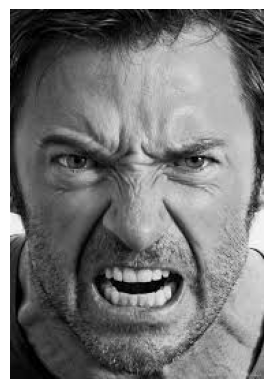

   angry: 31.18%
 disgust: 11.47%
    fear: 11.47%
   happy: 11.47%
     sad: 11.47%
surprise: 11.47%
 neutral: 11.47%


In [39]:
#predict image
image_path = "datas/angry_face.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()
predicted_class = predict(model, image, transform,CLASSES)


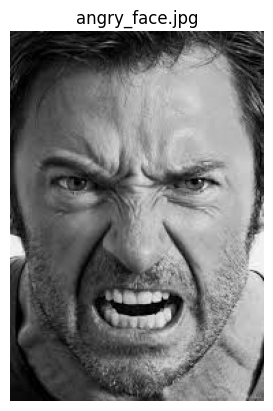

   angry: 31.18%
 disgust: 11.47%
    fear: 11.47%
   happy: 11.47%
     sad: 11.47%
surprise: 11.47%
 neutral: 11.47%


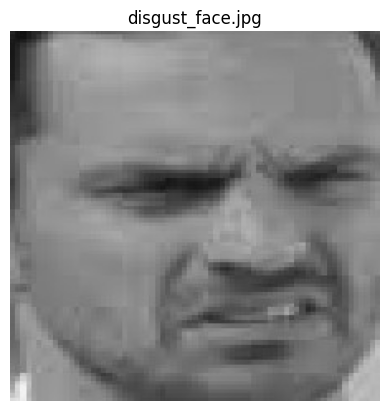

   angry: 12.04%
 disgust: 11.56%
    fear: 11.56%
   happy: 11.56%
     sad: 30.17%
surprise: 11.56%
 neutral: 11.56%


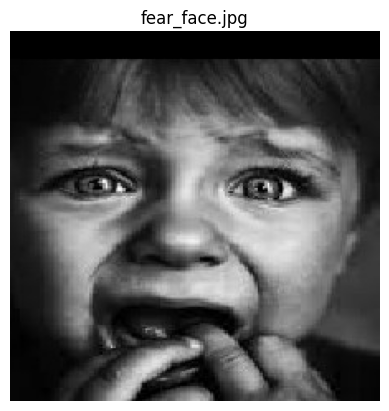

   angry: 11.47%
 disgust: 11.47%
    fear: 31.18%
   happy: 11.47%
     sad: 11.47%
surprise: 11.47%
 neutral: 11.47%


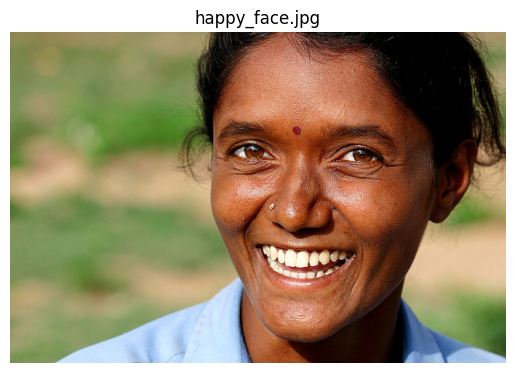

   angry: 11.47%
 disgust: 11.47%
    fear: 11.47%
   happy: 31.18%
     sad: 11.47%
surprise: 11.47%
 neutral: 11.47%


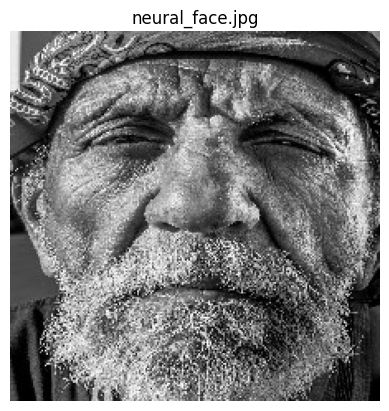

   angry: 11.47%
 disgust: 11.47%
    fear: 11.47%
   happy: 11.47%
     sad: 11.47%
surprise: 11.47%
 neutral: 31.18%


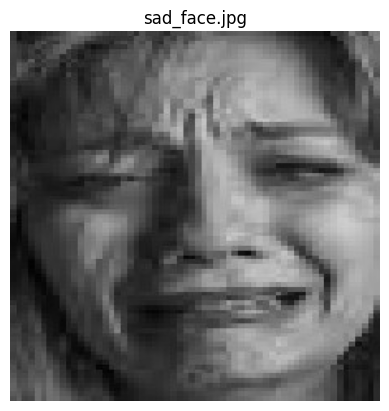

   angry: 11.47%
 disgust: 11.47%
    fear: 11.47%
   happy: 11.47%
     sad: 31.18%
surprise: 11.47%
 neutral: 11.47%


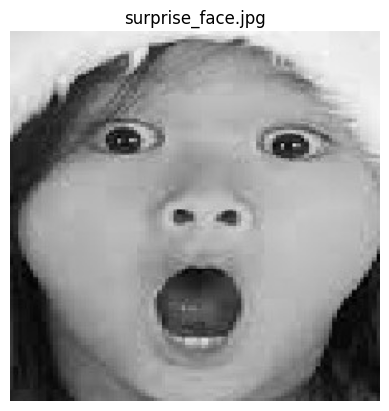

   angry: 11.47%
 disgust: 11.47%
    fear: 11.47%
   happy: 11.47%
     sad: 11.47%
surprise: 31.18%
 neutral: 11.47%


In [71]:


# Path to the folder containing the images
folder_path = 'datas/'

# Get the list of image files in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Plot each image
for file in image_files:
    # Load the image
    image_path = os.path.join(folder_path, file)
    img = Image.open(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks
    plt.title(file)  # Show the file name as the title
    plt.show()
    predicted_class = predict(model, img, transform,CLASSES)


In [7]:
from torchsummary import summary
model.to(device)
summary(model,(1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 47, 47]             640
            Conv2d-2          [-1, 128, 46, 46]          65,664
            Conv2d-3          [-1, 256, 24, 24]         131,328
            Conv2d-4          [-1, 256, 12, 12]         590,080
            Conv2d-5            [-1, 256, 6, 6]         590,080
            Linear-6                 [-1, 1024]       2,360,320
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 128]          65,664
           Linear-11                    [-1, 7]             903
Total params: 4,329,479
Trainable params: 4,329,479
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw